**tradHarvest** <br>
by $\text{Rishabh Pomaje}$

*Abstract*
- A classical approach to address issues faced in energy harvesting. 
- Using (7, 4) Hamming channel code.

In [14]:
# Importing the required dependencies :
import numpy as np 
import matplotlib.pyplot as plt 
import itertools
%config InlineBackend.figure_format='svg'

> Function Definitions

In [15]:
def hamming_encoder(input_stream, gnrtr_matrix) :
    """
    Function that first generates a codebook depending on the generator matrix 
    (provide as a numpy multi-dimensional ndarray). 
    Using that codebook, it performs the channel coding using Hamming codes.
    Returns a channel coded bit stream generated as per the Generator Matrix specified.
    """  
    input_size = len(input_stream)
    # k = length of the input packet ; n = length of the output packet
    k, n = np.shape(gnrtr_matrix)
    # Generating the codebook :
    code_book = np.array([], dtype=int)
    possible_inputs = [list(i) for i in itertools.product([0, 1], repeat=k)]
    for i in range(2 ** k) :
        code_word = np.array(np.matmul(possible_inputs[i], gnrtr_matrix) % 2)
        code_book = np.append(code_book, code_word) 
    code_book = code_book.reshape(2 ** k, n)
    # Encoding the stream using the codebook :
    # Zero Padding if required :
    # pad_length = input_size % k
    # input_stream = np.append(input_stream, np.zeros(pad_length, dtype=int))
    
    index = 0
    channel_coded_stream = []
    for i in range(input_size // k) :
        temp = input_stream[index:index+4]
        asgn_id = np.sum(temp * 2 ** np.arange(k - 1, -1, -1))
        channel_coded_stream.append(code_book[asgn_id])
        index = index + k
        
    channel_coded_stream = np.array(channel_coded_stream)

    return channel_coded_stream.flatten()

def BPSK_mapper(input_stream, energy_per_symbol) :
    """
    Function to perform constellation mapping on the input stream as per BPSK with given energy per symbol.
    Returns a ndarray consisting of complex symbols, each with magnitude energy per symbol.
    """
    output_stream = np.where(input_stream == 0, np.sqrt(energy_per_symbol), -1 * np.sqrt(energy_per_symbol))
    return output_stream

def BPSK_demapper(rx_stream) :
    """
    Function to perform BPSK constellation demapping
    Uses the MAP -> MLE -> Minimum distance method. The sufficient statistic used is the real part of the input 
    (possibly complex) signal.
    Returns the bit stream as per the minimum distance rule for demodulation.
    """
    rx_bits = np.where(np.real(rx_stream) > 0 , 0, 1)
    return rx_bits

def hamming_decoder(rx_stream, parity_chk_matrix):
    """
    Function to perform hard decision syndrome decoding for Hamming codes, given a bit stream and parity check matrix 
    as input.
    Returns 't-error' corrected stream. The current implementation is matrix based and hence inefficient.
    NOTE: The matrices provided as inputs to this function must be ndarray with dtype = int.
    """
    # Get the size of the input stream and dimensions of the parity check matrix
    input_size = len(rx_stream)
    k_1, n = parity_chk_matrix.shape
    k = n - k_1

    decoded_stream = np.zeros((input_size // n, k), dtype=int)
    # Generating the syndrome book :
    possible_single_errors = np.eye(n, dtype=int) 
    syndrome_book = parity_chk_matrix.T
    # Performing the syndrome decoding :
    num_blocks = input_size // n 
    for idx in range(num_blocks):
        rx_packet = rx_stream[idx * n: (idx + 1) * n]  # Extract packet for processing
        syndrome = np.matmul(rx_packet, parity_chk_matrix.T) % 2
        if np.sum(syndrome) != 0 :
        # Correcting 1-bit errors :
            for j in range(n):
                if np.array_equal(syndrome, syndrome_book[j]):
                    rx_packet = np.bitwise_xor(rx_packet, possible_single_errors[j])
        decoded_stream[idx] = rx_packet[:k]  # Append the corrected packet
        
    return decoded_stream.flatten()

def ML_Detection(rx_signal, G, E_sym) :
    """ 
    Function to perform Maximum Likelihood Decoding.
    Currently only for (7, 4) Hamming Code
    """
    # Matrix of all possible codewords :
    n = 7
    k = 4
    code_book = np.array([], dtype=int)
    possible_inputs = [list(i) for i in itertools.product([0, 1], repeat=k)]
    for i in range(2 ** k) :
        code_word = np.array(np.matmul(possible_inputs[i], G) % 2)
        code_book = np.append(code_book, code_word)
    C = BPSK_mapper(code_book, E_sym)  
    code_book = code_book.reshape(2 ** k, n)
    C = C.reshape(2 ** k, n)
    # Finding the MLD Estimates :
    n_blocks = len(rx_signal) // n
    estimates = []
    for i in range(n_blocks):
        start_idx = i * n
        end_idx = (i + 1) * n
        received_segment = rx_signal[start_idx:end_idx]
        distances = [np.linalg.norm(C[j] - received_segment) for j in range(2**k)]
        nearest_codeword_idx = np.argmin(distances)
        nearest_codeword = code_book[nearest_codeword_idx]  # Extracting the first 4 bits
        estimates.append(np.array(nearest_codeword[0:4]))
    
    return np.array(estimates).flatten()

# Comparison and Analysis functions    
def calcBER(original_message, estimated_message) :
    """ 
    Function to calculate the bit-error rate 
    """
    n_errors = 0
    for i in range(len(original_message)) :
        if original_message[i] != estimated_message[i] :
            n_errors += 1
    return [n_errors, n_errors / len(original_message)]

def calcBLER(original_message, estimated_message, block_length) :
    """ 
    Function to calculate the block error rate 
    """
    n_errors = 0
    n_blocks = len(original_message) // block_length
    idx = 0
    for _ in range(n_blocks) :
        if not np.all(original_message[idx:idx+block_length] == estimated_message[idx:idx+block_length]) :
            n_errors += 1 
        idx += block_length  
    return [n_errors, n_errors / n_blocks]      

In [16]:
# Uncoded and Coded block lengths 
k = 4
n = 7
# Information Rate 
R = k / n
# Energy per bit 
E_b = 1 
# Signal-Noise-Ratio (SNR) range in dB and linear scale :
SNR_dB = np.linspace(-4, 8, 25)
n_values = len(SNR_dB)
SNR_lin = 10 ** (SNR_dB / 10)
# Fixed Variance of only real component (I) noise for a particular SNR
noise_var_coded = 1 / (2 * R * SNR_lin)
noise_var_uncoded = 1 / (2 * SNR_lin)

# Channel Coding matrices :
# Generator matrix for (7, 4) Hamming Code :
G = np.array([
        [1, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 1, 0, 1],
        [0, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]
    ], dtype=int)
# Parity Check Matrix :
H = np.array([
    [1, 1, 0, 1, 1, 0, 0],
    [1, 0, 1, 1, 0, 1, 0],
    [0, 1, 1, 1, 0, 0, 1]
    ], dtype=int)

> Data Generation 

In [17]:
# Generating random binary bit stream as our data :
n_bits = 4 * (10 ** 6)
n_bits_c = n_bits * n // k 
binary_stream_tx = np.random.randint(0, 2, n_bits)
print(f'Sample :{binary_stream_tx[:10]}')
type(binary_stream_tx[0])

Sample :[0 0 0 1 1 1 0 0 1 1]


numpy.int32

> Channel Coding 
- Using (7, 4) Hamming Code 

In [18]:
channel_coded_stream_tx = hamming_encoder(binary_stream_tx, G)
print(len(channel_coded_stream_tx))

7000000


> Constellation Mapping 
- Per bit energies :
- BPSK : {$\pm \sqrt{E_{b}}$}
- $E_{uncoded} = 1 = \text{Budgeted from the hardware at the final output}$
\begin{equation}
E_{coded} = E_{uncoded} \times k / n = E_{uncoded} \times R
\end{equation}
- $R$ = Information Rate 
- $\color{red}{Note}$ : This difference in energy per bit needs to be compensated in either symbol energy or the noise variance. I have arbitrarily chosen it to be the noise variance.

In [19]:
# Energy Samples harvested : According to Chi-Squared(3) distribution 
energy_train_c = np.random.chisquare(3, n_bits_c)

# For coded stream :
signal_stream_tx_c = BPSK_mapper(channel_coded_stream_tx, E_b)
idx = 0 
# Normalising the signal before energising it 
while idx+n < len(signal_stream_tx_c) :
    signal_stream_tx_c[idx:idx+n] = signal_stream_tx_c[idx:idx+n] / np.linalg.norm(signal_stream_tx_c[idx:idx+n])
    idx = idx + n 
# Samples :
print(signal_stream_tx_c[:10])
# Energising the signal using Chi-Squared distribution :
signal_stream_tx_c = energy_train_c * signal_stream_tx_c
print(signal_stream_tx_c)

[ 0.37796447  0.37796447  0.37796447 -0.37796447 -0.37796447 -0.37796447
 -0.37796447 -0.37796447 -0.37796447  0.37796447]
[ 0.47745309  0.08567629  0.2980959  ... -2.39047673 -0.26582649
 -2.87549166]


> Modelling the channel followed by the receiver :
- AWGN channel with $w \sim \mathcal{CN}(0, N_0)$
- Channel model : $Y = X + W$

- Hard Decision + Syndrome decoding 

In [20]:
# Coded Coherent Detection :
count = 0
BLER_hard = []
for noise in noise_var_coded :
    # AWGN Channel + fading :
    awgn_c = np.random.normal(0, np.sqrt(noise), n_bits_c) + 1j * np.random.normal(0, np.sqrt(noise), n_bits_c)
    signal_stream_rx_c = signal_stream_tx_c + awgn_c
    # BPSK Demapping (Hard Decoding) :
    binary_stream_rx_c = BPSK_demapper(signal_stream_rx_c)
    # Hamming Decoder :
    binary_stream_rx = hamming_decoder(binary_stream_rx_c, H)
    # Analysing the error :
    _, BLER = calcBLER(binary_stream_tx, binary_stream_rx, k)
    BLER_hard.append(BLER)
    count += 1
    print(f'Progress : {100 * count // n_values} %', end='\r')

> Visualizing the results 

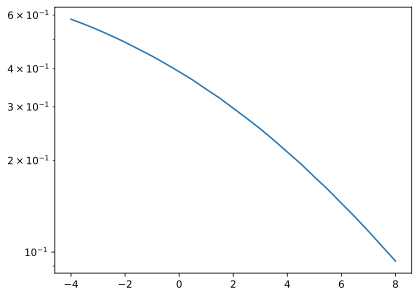

In [22]:
fig, axes = plt.subplots()
axes.semilogy(SNR_dB, BLER_hard)

In [24]:
print(f'BLER_hard = {BLER_hard}')

BLER_hard = [0.581305, 0.559514, 0.536377, 0.512669, 0.488556, 0.4638, 0.439983, 0.415272, 0.391009, 0.367479, 0.342623, 0.320251, 0.296759, 0.274935, 0.253964, 0.233205, 0.213085, 0.194969, 0.17669, 0.160559, 0.144689, 0.130624, 0.117148, 0.104638, 0.093506]
